In [1]:
import wisps
import wisps.simulations as wispsim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bisect, numba
from tqdm import tqdm
%matplotlib inline

In [2]:
LF=wisps.LUMINOSITY_FUCTION
LFDES=wisps.DES_LUMINOSITY_FUCTION
MAGLIMITS=wisps.MAG_LIMITS
PNTS=wisps.OBSERVED_POINTINGS
CANDS=wisps.datasets['candidates']
DIST_DATAFRAME=pd.DataFrame.from_records([x.samples for x in wisps.OBSERVED_POINTINGS])
SIMULATED_DIST=wispsim.simulate_spts()

In [3]:
def drop_nan(x):
    x=np.array(x)
    return x[(~np.isnan(x)) & (~np.isinf(x)) ]

100%|██████████| 13/13 [00:00<00:00, 64.87it/s]


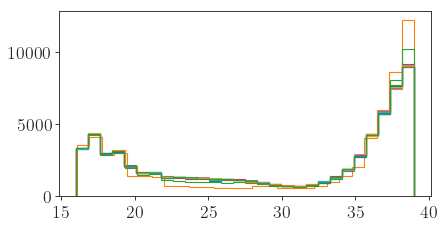

In [4]:
fig, ax=plt.subplots()
for idx in tqdm(np.arange(13)):
    spts=drop_nan(SIMULATED_DIST['spts'][idx][:,0])
    #ages=drop_nan(SIMULATED_DIST['ages'][idx][:,0])
    h=plt.hist(spts,  histtype='step', bins='auto')

100%|██████████| 13/13 [00:01<00:00, 11.75it/s]


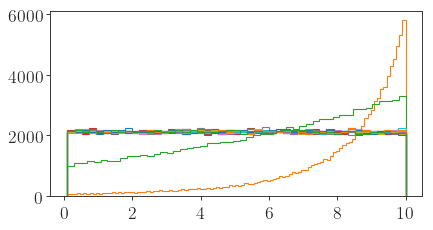

In [5]:
fig, ax=plt.subplots()
for idx in tqdm(np.arange(13)):
    spts=drop_nan(SIMULATED_DIST['ages'][idx])
    #ages=drop_nan(SIMULATED_DIST['ages'][idx][:,0])
    h=plt.hist(spts,  histtype='step', bins='auto')

100%|██████████| 17/17 [00:01<00:00, 14.13it/s]


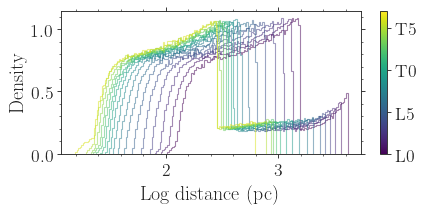

In [6]:
fig, ax=plt.subplots()
spt_dists={}

import matplotlib
from matplotlib import cm

norm = matplotlib.colors.Normalize(vmin=20., vmax=37.0)


for idx in tqdm(np.arange(20., 37.)):
    spt_dists[idx]=np.log10(np.concatenate(DIST_DATAFRAME[idx].values))
    h=ax.hist(np.log10(np.concatenate(DIST_DATAFRAME[idx].values)),color=cm.viridis(norm(idx)),\
               histtype='step',  bins='auto', alpha=0.5, 
               normed=True)


sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
br=plt.colorbar(sm, ticks=np.arange(20., 40., 5 ))
br.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

ax.set_xlabel('Log distance (pc)')
ax.set_ylabel('Density')
plt.minorticks_on()
plt.tight_layout()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.savefig(wisps.OUTPUT_FIGURES+'/distance_distribution.pdf')

In [7]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [8]:
pnts=wisps.OBSERVED_POINTINGS

In [9]:
#big_skycoord= []

In [10]:
#for p in pnts:
#    big_skycoord.append(SkyCoord(ra=p.coord.ra, dec=p.coord.dec, distance=np.concatenate([p.samples[k] for k in p.samples.keys()])*u.pc))

In [11]:
#skcoord=SkyCoord(big_skycoord)

In [12]:
#x, y, z=skcoord.galactic.cartesian.xyz

In [13]:
#r=(x**2+y**2)**0.5

In [14]:
import seaborn as sns

In [15]:
import wisps
import numpy as np
from wisps.simulations import custom_volume_correction, Pointing
from wisps import get_distance
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
wisps.MAG_LIMITS['wisps']

{'F110W': [22.0, 18.0], 'F140W': [21.5, 16.0], 'F160W': [21.5, 16.0]}

In [17]:
coord=SkyCoord(ra=50*u.deg, dec=50*u.deg)

In [18]:
p=Pointing(coord=PNTS[0].coord)

In [19]:
p.survey='wisps'
p.mag_limits=wisps.MAG_LIMITS['wisps']
p.compute_distance_limits()
p.computer_volume()

Text(0.5, 0, 'distance (pc)')

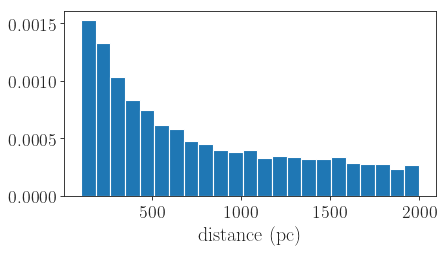

In [20]:
h=plt.hist(p.random_draw(2000, 100, 10000 ), bins='auto', normed=True)
plt.xlabel('distance (pc)')

In [21]:
vals, cdf=p.cdf(100, 2000)

Text(0.5, 0, 'distance (pc)')

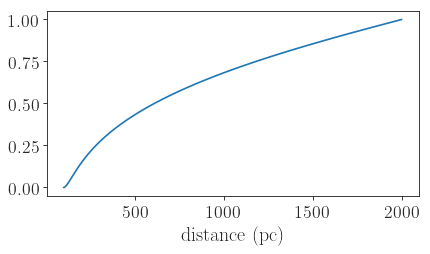

In [22]:
#plt.plot(vals, cdf)
plt.plot(vals,cdf)
plt.xlabel('distance (pc)')

In [23]:
#DIST_DATAFRAME.applymap(np.nanmin)

In [24]:
lms=pd.DataFrame.from_records([x.dist_limits for x in wisps.OBSERVED_POINTINGS])

In [25]:
big_skycoord= []
for p in pnts:
    big_skycoord.append(SkyCoord(ra=p.coord.ra, dec=p.coord.dec, distance=np.concatenate([p.samples[20] for k in p.samples.keys()])*u.pc))
    
small_skycoord= []
for p in pnts:
    small_skycoord.append(SkyCoord(ra=p.coord.ra, dec=p.coord.dec, distance=np.concatenate([p.samples[37] for k in p.samples.keys()])*u.pc))

In [26]:
cood=SkyCoord(big_skycoord)
cood2=SkyCoord(small_skycoord)

In [27]:
x, y, z=cood.galactic.cartesian.xyz
x2, y2, z2=cood2.galactic.cartesian.xyz

In [28]:
idx=np.arange(len(cood))

In [29]:
ints=np.random.choice(idx, size=10000)

In [30]:
xr=x[ints]
yr=y[ints]
zr=z[ints]


xr2=x2[ints]
yr2=y2[ints]
zr2=z2[ints]

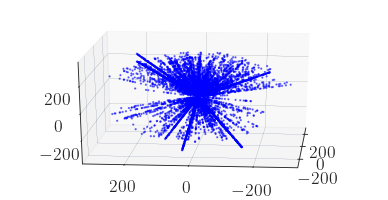

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
 
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xr, yr, zr, s=1., alpha=0.1, color='r' )
ax.scatter(xr2, yr2, zr2,  s=1., alpha=0.5, color='b')

#ax.

ax.view_init(20, 185)
plt.show()


In [32]:
@numba.vectorize
def proper_motion(vt, d):
    """
    mu in arcsec/y
    d in pc
    vt in
    """
    return vt/(4.74*d)

@numba.vectorize("float64(float64)")
def probability_of_detection_smearing(d):
    #draw a uniform 
    vt=np.random.uniform(1, 100)
    mu= proper_motion(vt, d)
    if mu*2 >0.1:
        return 1.
    if mu*2<=0.1:
        return 0.

Text(0.5, 0, 'r')

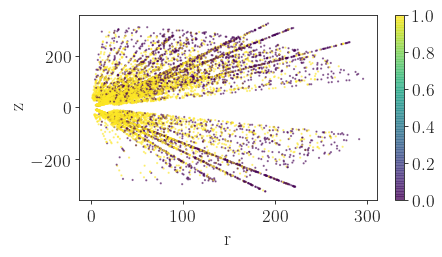

In [34]:
r2=(xr2**2+yr2**2)**0.5
d2=(xr2**2+yr2**2+zr2**2)**0.5
sl=probability_of_detection_smearing(d2.value)
f=plt.scatter(r2, zr2,  s=1., alpha=0.5, c=sl, cmap='viridis')
plt.colorbar(f)
plt.ylabel('z')
plt.xlabel('r')

Text(0.5, 0, 'r')

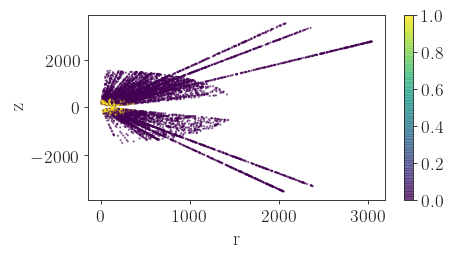

In [35]:
r=(xr**2+yr**2)**0.5
d=(xr**2+yr**2+zr**2)**0.5
sl=probability_of_detection_smearing(d.value)
f=plt.scatter(r, zr,  s=1., alpha=0.5, c=sl, cmap='viridis')
plt.colorbar(f)

plt.ylabel('z')
plt.xlabel('r')